# Titanic survival prediction 

First we import the data and the relevant python modules:

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('../input/train.csv')
target = train.Survived.astype('category', ordered=False)
train.drop('Survived', axis=1)

test = pd.read_csv('../input/test.csv')
PassengerId = test.PassengerId

In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploratory Data Analysis

A much higher percentage of female passengers survived the titanic shipwreck as compared to the male passengers.

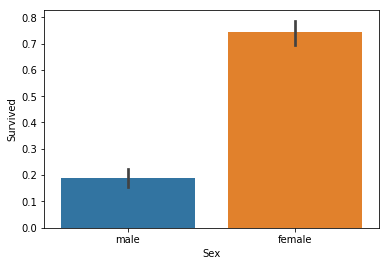

In [3]:
sns.barplot(x='Sex', y='Survived', data=train);

Similarly the graph below suggests that the ticket class can also be a useful indicator in predicting the survival.

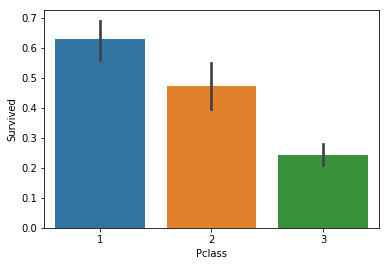

In [4]:
sns.barplot(x='Pclass', y='Survived', data=train);

Now we look at how the gender within the ticket classes affects the chance of survival.

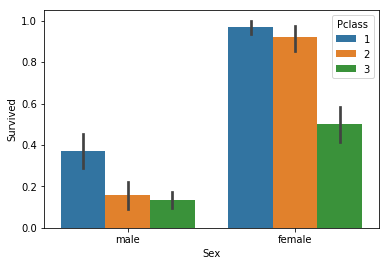

In [5]:
sns.barplot(x='Sex', y='Survived', hue = 'Pclass', data=train);

It seems like for both genders, ticket class play a role in predicting the chance of survival. 

Next we check the survival rate among both genders within the three ticket classes.

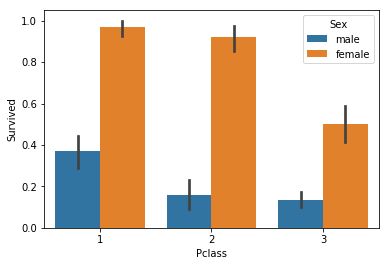

In [6]:
sns.barplot(x='Pclass', y='Survived', hue = 'Sex', data=train);

It seems that though the gender affects the chance of survival for all the three ticket classes, its effect is most pronounced for the second class passenger and least prounced for the third class. This is also reflected by the slopes in the graph below.

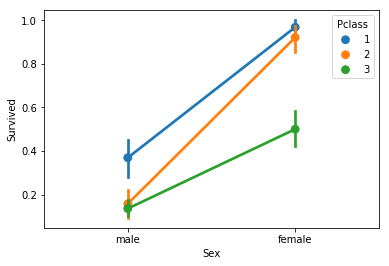

In [7]:
sns.pointplot(x='Sex', y='Survived', hue = 'Pclass', data=train);

Within each gender, surviving passengers have a higher median fare than those who did not survive. However, the gap in fares between those who survived and who did not is more pronounced among females. 

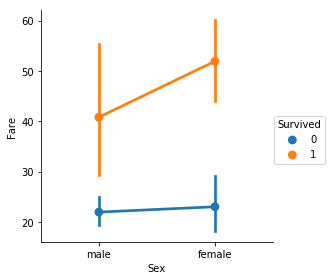

In [8]:
sns.factorplot(x='Sex', y='Fare', hue='Survived', data=train);

The higher survival rate for female passengers can be explained by their higher fares to some extent. 

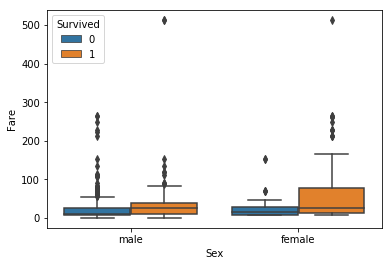

In [9]:
 sns.boxplot(x='Sex', y='Fare', hue='Survived', data=train);

Does it mean that when we compare the survival rate for male and female passengers who paid similar fares, the men have higher survival than women? The following two graphs indicates otherwise.

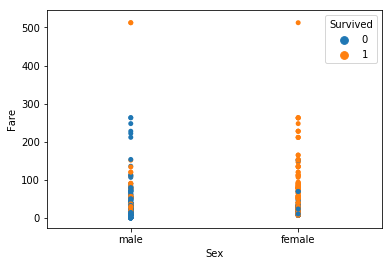

In [10]:
 sns.stripplot(x='Sex', y='Fare', hue='Survived', data=train);

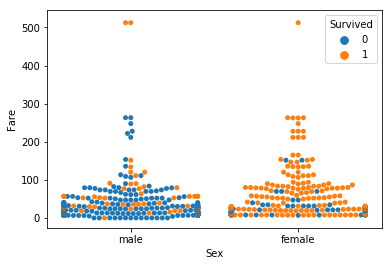

In [11]:
 sns.swarmplot(x='Sex', y='Fare', hue='Survived', data=train);

We observed that though each of the feature - Sex, Class and Fare is closely related to the survival, there is an interesting interplay among them. I have not included the interplay among the other remaining features to keep the kernel length as short as possible, but the kernels in the references mentioned below have explored it in more detail.
After we train the model, we will check again which features the model considered more important than others in predicting the survival.

# Feature Engineering

In [12]:
train.shape

(891, 12)

The training data consists of 891 passengers which means the sample size is small, so a complex model runs a chance of overfitting to the training set and not predicting as well on the unseen test data. Keeping this in view, it is desirable to be selective about which features to include in our model.

In [13]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

A lot of values from the Age and Cabin columns are missing. We decide to fill the Age column whereas discard the Cabin column. 

The title of the passengers can be extracted from their names. The titles have a strong correlation with gender and when age as well as the number of parent-children and sibling-spouses are also accounted, the titles does not seems to add much information and hence can be discarded. However, the titles are useful to fill the missing values in age column since passengers with the same title tend to have similar age.

In [14]:
def get_Titles(df):
    df.Name = df.Name.apply(lambda name: re.findall("\s\S+[.]\s", name)[0].strip())
    df = df.rename(columns = {'Name': 'Title'})
    df.Title.replace({'Ms.': 'Miss.', 'Mlle.': 'Miss.', 'Dr.': 'Rare', 'Mme.': 'Mr.', 'Major.': 'Rare', 'Lady.': 'Rare', 'Sir.': 'Rare', 'Col.': 'Rare', 'Capt.': 'Rare', 'Countess.': 'Rare', 'Jonkheer.': 'Rare', 'Dona.': 'Rare', 'Don.': 'Rare', 'Rev.': 'Rare'}, inplace=True)
    return df

We first group the passengers as per their titles and then fill the missing values for the age using the median age for each group.

In [15]:
def fill_Age(df):
    df.Age = df.Age.fillna(df.groupby("Title").Age.transform("median"))
    return df

We observe that multiple passengers were traveling on the same ticket. 

In [16]:
train.Ticket.value_counts()[:10]

1601            7
347082          7
CA. 2343        7
CA 2144         6
347088          6
3101295         6
S.O.C. 14879    5
382652          5
17421           4
LINE            4
Name: Ticket, dtype: int64

Often the tickets are shared among family members with the same last name. 

In [17]:
train[train.Ticket == "CA. 2343"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


Instead of having seperate features for the number of parent-children and sibling-spouse, we can use the family size as a single feature for accompanying family members. So, the two features - family size and co-passengers on the same ticket are closely related. However, it turns out they are not the same.
In some cases, passengers that appear to be traveling alone by account of their family size were part of a group traveling on the same ticket. 

In [18]:
train[train.Ticket == "1601"]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
74,75,1,3,"Bing, Mr. Lee",male,32.0,0,0,1601,56.4958,NaN,S
169,170,0,3,"Ling, Mr. Lee",male,28.0,0,0,1601,56.4958,NaN,S
509,510,1,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S
643,644,1,3,"Foo, Mr. Choong",male,NaN,0,0,1601,56.4958,NaN,S
692,693,1,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S
826,827,0,3,"Lam, Mr. Len",male,NaN,0,0,1601,56.4958,NaN,S
838,839,1,3,"Chip, Mr. Chang",male,32.0,0,0,1601,56.4958,NaN,S


In other cases, the family members were not traveling on the same ticket.

In [19]:
train.loc[[69, 184]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
69,70,0,3,"Kink, Mr. Vincenz",male,26.0,2,0,315151,8.6625,NaN,S
184,185,1,3,"Kink-Heilmann, Miss. Luise Gretchen",female,4.0,0,2,315153,22.0250,NaN,S


To combine the two, a feature named group size is derived by taking the maximum of the family size and the number co-travelers of a passenger. 

In [20]:
def get_Group_size(df):
    Ticket_counts = df.Ticket.value_counts()
    df['Ticket_counts'] = df.Ticket.apply(lambda x: Ticket_counts[x])
    df['Family_size'] = df['SibSp'] + df['Parch'] + 1
    df['Group_size'] = df[['Family_size', 'Ticket_counts']].max(axis=1)
    return df

I have noticed that using the feature `Embarked` does not improve my model, so I discarded it as well. The feature for gender is encoded as numerical categories and only five features are kept. 

In [21]:
def process_features(df):
    df.Sex = df.Sex.astype('category', ordered=False).cat.codes
    features_to_keep = ['Age', 'Fare', 'Group_size', 'Pclass', 'Sex']
    df = df[features_to_keep]
    return df

We can either process the training and test set seperately or together. Processing them together would mean that while calculating the group size for passengers in the training set, the ticket information about those in the test set is used and vice versa. Similarly, the missing values for age in the training set can either be imputed using the age of passengers from both the training and test set or simply the training set alone. Processing them together would certainly account for considerable data-leakage from the test set to the training set and the resulting model will likely overfit to the test set. In most scenarios, this is bad news, for example online predictions where the model would generalize poorly for unseen future test data. [Data-leakage can be prevented by using scikit-learn Pipelines](https://www.kaggle.com/dansbecker/data-leakage) which is also especially useful to keep the validation and training sets separate while tuning the hyperparameters. The Titanic survival prediction is a different story however, and later on in the next section, I have taken the liberty to deliberately not follow the standard best practise and explained my reasons below.

Processing the training and test set seperately:

In [22]:
def process_data(df):
    df = df.copy()
    df = get_Titles(df)
    df = fill_Age(df)
    df = get_Group_size(df)
    df = process_features(df)
    return df

X_train, X_test = process_data(train), process_data(test)

In [23]:
X_train.head()

,Age,Fare,Group_size,Pclass,Sex
0,22.0,7.2500,2,3,1
1,38.0,71.2833,2,1,0
2,26.0,7.9250,1,3,0
3,35.0,53.1000,2,1,0
4,35.0,8.0500,1,3,1


In [24]:
correlation_matrix = X_train.corr()
correlation_matrix

,Age,Fare,Group_size,Pclass,Sex
Age,1.000000,0.097947,-0.256371,-0.354189,0.104921
Fare,0.097947,1.000000,0.334278,-0.549500,-0.182333
Group_size,-0.256371,0.334278,1.000000,0.018783,-0.191490
Pclass,-0.354189,-0.549500,0.018783,1.000000,0.131900
Sex,0.104921,-0.182333,-0.191490,0.131900,1.000000


The correlation matrix measures the linear dependence of the features and it is desirable to have features that have little or no depedence on each other. Decision tree based algorithms including boosted trees are robust to correlated features, so they are safer to use. However, using correlated features makes prediction less accurate for many machine learning algorithms, for example linear regression. It can remedied by using Principal Component Analysis to obtain uncorrelated features.  It is a good practise to know the correlation before proceeding to build models.

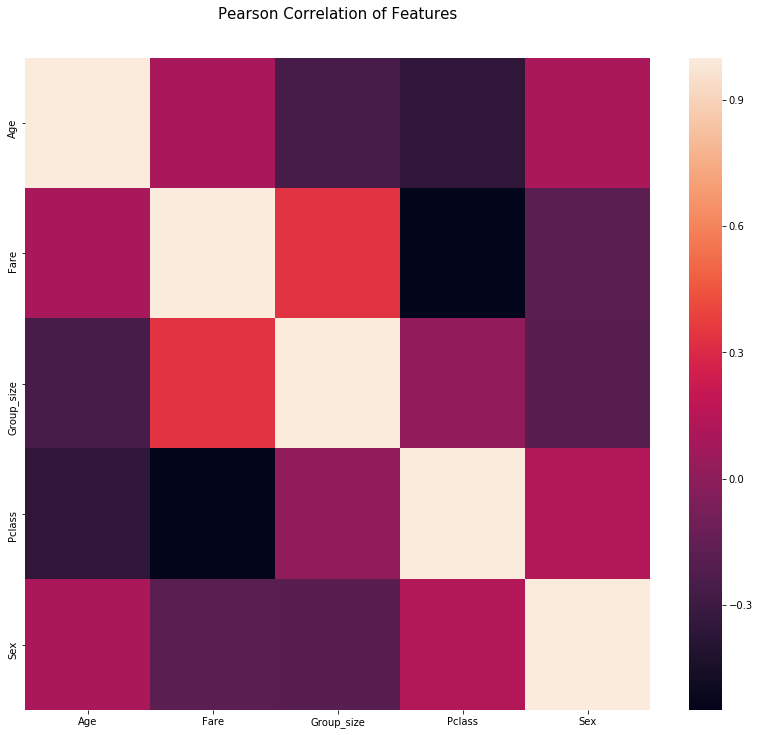

In [25]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(correlation_matrix);

The heatmap suggests the selected features are not overly dependent on each other. 

# Building the model

XGBoost has an in-built cross validation function that will help us to decide the number of estimators for the gradient boosting tree. 

In [26]:
dtrain = xgb.DMatrix(data=X_train, label=target)
params = { 
    "Objective": 'gbtree',
    "eval_metric": 'error',
    "eta": 0.05
}
cv = xgb.cv(params=params, dtrain=dtrain, num_boost_round=100, nfold=5, seed=41, early_stopping_rounds= 10)
cv.tail(1)

,test-error-mean,test-error-std,train-error-mean,train-error-std
8,0.17174,0.029971,0.113917,0.002874


I have left out the detailed hyperparamter tuning to get the best XGBoost classifier. This minimalistic model can achieve an accuracy of around 0.79 with optimal number of estimators, which is quite good for a single classifier for  this dataset. Using multiple XGBoost classifiers with different optimal paramters along with other classifiers in an ensemble has given me an accuracy score upwards of 0.82 which is top 3% in the leaderboard. 
The ensembling/stacking of dissimilar classifiers is a very effective way to improve performance, but it is a good learning process to try to make the best out of a single classfier.

Titanic sank only once and the passengers' age and their tickets were known before the tragedy.
Processing train and test set together in this case, to fill the missing values for Age and deriving the feature Group size, can be seen as using all information available to make predictions and thus striving to make a model that best predict the test set but disregard the performance on unseen examples outside of the test set. This will overfit the model to the test set, which is not the best practise in general, but can be argued to be desirable in this case where the test set is limited, fixed and known beforehand. Unsurpisingly, processing data together in the following way increases accuracy for the test set.

Processing the training and test set together (optional):

In [27]:
# Please comment this cell if you would decide on not processing the training and test set together:
def process_data_together(train, test):
    df = pd.concat([train, test], join='inner', keys=['train', 'test']).copy()
    df = get_Titles(df)
    df = fill_Age(df)
    df = get_Group_size(df)
    df = process_features(df)
    return df.loc['train'], df.loc['test']

X_train, X_test = process_data_together(train, test)

Irrespective of whether we process the training and test set together, after we decide on the hyperparameters (here `n_estimators=14`), we use the entire training set to retrain the model and then use this model to predict the test cases. 

In [28]:
xgbcl = XGBClassifier(n_estimators=14, seed=41)
xgbcl.fit(X_train, target)
print(xgbcl.score(X_train, target)) 

0.835016835016835


# Interpreting the model

Machine learning algorithms need not be the blackboxes, especially with the availability of various tools today. XGBoost has in-built functions to plot the decision tree as well as the importance of each feature. The heatmap to gauge the correlation of each feature with the predictor variable also adds a different perspective to understand the working of our model. Lastly, partial dependence plots are excellent to understand the relationship between individual features and the predictor variable.

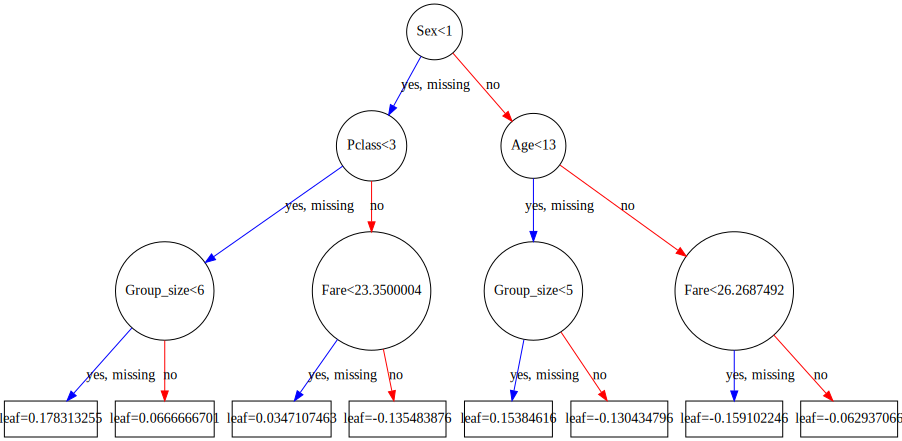

In [29]:
# xgb.plot_tree(xgbcl);
xgb.to_graphviz(xgbcl)

Here, Sex = 1 implies male and Sex = 0 implies female. In case of female passengers, ticket class is a deciding factor early on in the decision tree whereas for males, age plays that role.

In [ ]:
xgb.plot_importance(xgbcl);

Interestingly, gender is the least important feature in the model we built which is counterintuitive considering what is largely believed about the tragedy.

In [ ]:
X_w_target = X_train.copy()
X_w_target['Survived'] = target.astype('int64')
correlation_matrix_w_target = X_w_target.corr()
correlation_matrix_w_target

Indeed, the gender is the feature that is most highly correlated with survival among all with correlation coefficient of $-0.54$. It is a good demonstration of "Correlation does not imply causation".

In [ ]:
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features along with target variable', y=1.05, size=15)
sns.heatmap(correlation_matrix_w_target);

[Partial dependence plots](https://www.kaggle.com/dansbecker/partial-dependence-plots) are useful to see how continuous variables affect the model's predictions. They show us the relationship of a particular variable with target variable when all other features are kept constant. I am unaware of making `plot_partial_dependence` work on `XGBoost Classifier`, so I am rebuilding the model using its equivalent in `scikit-learn`, that is `GradientBoostingClassifier`. 

In [ ]:
gbcl = GradientBoostingClassifier(learning_rate=0.2, n_estimators=70)
gbcl.fit(X_train, target)
plot_partial_dependence(gbcl, X=X_train, features=[0, 1, 2], feature_names=['Age', 'Fare', 'Group_size'], grid_resolution=10);

This suggests that Age is a strong indicator of survival in the range of 0-10 years.

# Prediction and submission

In [ ]:
predictions = xgbcl.predict(X_test)
Predictions = pd.DataFrame({'PassengerId': PassengerId, 'Survived': predictions})
Predictions.to_csv('submission.csv', index=False)

 ## References for kernels
 * https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling
 * https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python
 * https://www.kaggle.com/pliptor/divide-and-conquer-0-82296

If you learned from the kernel and/or liked it, an upvote would be appreciated!